## **Confidence calculation**

How good is the Open buildings datasets to represent the households in the Maciço de Baturité?

We calculate the confidence of the dataset for each census tract in this notebook.

### **Lib**

In [172]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
from typing import Optional

import matplotlib.pyplot as plt

### **ETL**

Using the raw data from the open buildings dataset, select only the households located within the region of interest: Maciço de Baturité. 

In [15]:
class OpenBuildingsETL:
    '''
        Interface for running the ETL pipeline using the Open Buildings dataset.

        Args:
        -----
            path_to_raw_file: str.
            path_to_out_file: str.
            path_to_reference_geo: str. 
                Path to a set of reference shapes to be used for filtering the relevant
                households from the Open buildings dataset.
    '''
    def __init__(
        self, 
        path_to_raw_file: str,
        path_to_out_file: str,
        reference_geo: gpd.GeoDataFrame
    ):
        self.path_to_raw_file = path_to_raw_file
        self.path_to_out_file = path_to_out_file
        self.path_to_reference_geo = path_to_reference_geo
        self.reference_geo = None
        self.selected_points = None
        self.selected_data = None
        self.enforced_crs = enforced_crs

        self.id_column = "full_plus_code"
        self.sector_id_column = "CD_SETOR"
        self.base_columns = [
            self.id_column, "latitude", "longitude", "area_in_meters", "confidence"
        ]
        self.raw_geometry_column = "geometry"

    def extract(self):
        # -- load the reference shapes
        self.reference_geo = gpd.read_file(self.path_to_reference_geo)
        self.reference_geo = self.reference_geo.to_crs("EPSG:4326")
        # -- load the raw open buildings dataset
        data = pd.read_csv(self.path_to_raw_file)[self.base_columns]
        data["point"] = [ Point(lat,lon) for lat, lon in zip(data["longitude"], data["latitude"]) ]
        data = gpd.GeoDataFrame(data, geometry=data.point, crs="EPSG:4326")
        # -- keep only the points that are relevant for our analysis (households located within the shapes of 'reference_geo')
        self.selected_points = gpd.sjoin(data, self.reference_geo, how="inner", predicate="within")

    def transform(self):
        id_to_sector = dict(zip(self.selected_points[self.id_column], self.selected_points[self.sector_id_column]))
        # -- select only the points within the reference geo
        self.selected_data = pd.read_csv(self.path_to_raw_file)
        self.selected_data = self.selected_data[self.selected_data[self.id_column].isin(self.selected_points[self.id_column])].copy()
        self.selected_data["geometry"] = self.selected_data["geometry"].apply(wkt.loads)
        self.selected_data = gpd.GeoDataFrame(self.selected_data, geometry=self.selected_data.geometry)
        self.selected_data[self.sector_id_column] = self.selected_data[self.id_column].map(id_to_sector)

    def load(self):
        self.selected_data.to_file(self.path_to_out_file)

    def run_etl(self):
        self.extract()
        self.transform()
        self.load()

In [ ]:
# -- raw file as downloaded in the open buildings project website: https://sites.research.google/gr/open-buildings/#open-buildings-download
path_to_file = "C:/Users/Higor Monteiro/Documents/data/open_buildings/07b_buildings.csv.gz"
# -- transformed file: only residences within a given set of shapes
path_to_out_file = "C:/Users/Higor Monteiro/Documents/data/open_buildings/buildings_macico/open_buildings_macico.shp"

# -- path to reference shapes
reference_geo_path = "C:/Users/Higor Monteiro/Documents/data/open_buildings/setores_macico/SC_MACICO.shp"

In [ ]:
ob_etl = OpenBuildingsETL(path_to_file, path_to_out_file, reference_geo_path)
ob_etl.run_etl()

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_37808\654862408.py:43: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  self.selected_data.to_file(self.path_to_out_file)


### **Calculate confidence indices**

For now, we are going to quantify three main information for each census tract: Coverage, consistency and size bias.

In [334]:
path_to_out_file = "C:/Users/Higor Monteiro/Documents/data/open_buildings/buildings_macico/open_buildings_macico.shp"
reference_geo_path = "C:/Users/Higor Monteiro/Documents/data/open_buildings/setores_macico/SC_MACICO.shp"

selected_households = gpd.read_file(path_to_out_file)
macico_sectors = gpd.read_file(reference_geo_path)

In [438]:
def calculate_metrics(households_df, sectors_df):
    required_columns_right = [
        "CD_SETOR", "CD_MUN", "NM_MUN", "SITUACAO", "CD_SIT", 
        "CD_TIPO", "v0001", "v0002", "v0003", "v0005"
    ]
    required_columns_left = [
        "CD_SETOR", "confidence", "area_in_me"
    ]
    if any([ elem not in households_df.columns for elem in required_columns_left]):
        raise ValueError(f"{required_columns_left} not present")
    if any([ elem not in sectors_df.columns for elem in required_columns_right]):
        raise ValueError(f"{required_columns_right} not present")

    for col in ["v0001", "v0002", "v0003"]:
        sectors_df[col] = sectors_df[col].astype(int)
    sectors_df["v0005"] = sectors_df["v0005"].apply(lambda x: x.replace(",", ".") if type(x)==str else x).astype(float)
    sectors_info = sectors_df[required_columns_right].copy()
    
    
    # -- filter by area before (too small "houses" are likely to be wrong classifications)
    households_df = households_df[households_df["area_in_me"]>8] # -- >8 is conservative
    modes = ['all', 'mid', 'high', 'very_high']
    confidences = [0.0, 0.70, 0.75, 0.80]
    # -- get the households count for each level of confidence
    household_n = [
        households_df[households_df["confidence"]>=confidence].groupby("CD_SETOR")['full_plus_'].count().reset_index().rename({"full_plus_": f"total_households_{suffix}"}, axis=1)
        for confidence, suffix in zip(confidences, modes)
    ]
    for cur_household_count in household_n:
        sectors_info = sectors_info.merge(cur_household_count, on="CD_SETOR", how="inner")

    sectors_info["mean_pop_per_household"] = sectors_df["v0001"]/sectors_df["v0002"] # -- 'v0005' seems off

    # -- calculate coverage indicator
    for ix, suffix in enumerate(modes):
        # -- coverage indicator
        sectors_info[f"coverage_indicator_{suffix}"] = sectors_info[f"total_households_{suffix}"]/sectors_info["v0002"]
        # -- pop consistency
        expected_pop = sectors_info[f"total_households_{suffix}"]*sectors_info["mean_pop_per_household"]
        sectors_info[f"pop_consistency_{suffix}"] = expected_pop/sectors_info["v0001"]
        # -- average bias
        implied_average = sectors_info["v0001"]/sectors_info[f"total_households_{suffix}"]
        sectors_info[f"pop_average_bias_{suffix}"] = implied_average/sectors_info["mean_pop_per_household"]

    return sectors_info

sectors_info = calculate_metrics(selected_households, macico_sectors)

In [439]:
sectors_info

,CD_SETOR,CD_MUN,NM_MUN,SITUACAO,CD_SIT,CD_TIPO,v0001,v0002,v0003,v0005,...,pop_average_bias_all,coverage_indicator_mid,pop_consistency_mid,pop_average_bias_mid,coverage_indicator_high,pop_consistency_high,pop_average_bias_high,coverage_indicator_very_high,pop_consistency_very_high,pop_average_bias_very_high
0,230015005000001,2300150,Acarape,Urbana,1,0,498,181,181,2.9,...,1.131250,0.828729,0.828729,1.206667,0.729282,0.729282,1.371212,0.513812,0.513812,1.946237
1,230015005000002,2300150,Acarape,Urbana,1,0,629,214,214,3.1,...,1.251462,0.747664,0.747664,1.337500,0.668224,0.668224,1.496503,0.500000,0.500000,2.000000
2,230015005000003,2300150,Acarape,Urbana,1,0,655,235,235,3.2,...,1.366279,0.680851,0.680851,1.468750,0.617021,0.617021,1.620690,0.485106,0.485106,2.061404
3,230015005000004,2300150,Acarape,Urbana,1,0,705,276,276,3.0,...,1.295775,0.681159,0.681159,1.468085,0.608696,0.608696,1.642857,0.438406,0.438406,2.280992
4,230015005000005,2300150,Acarape,Urbana,1,0,1143,401,401,3.2,...,1.126404,0.798005,0.798005,1.253125,0.698254,0.698254,1.432143,0.528678,0.528678,1.891509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,231160305000041,2311603,Redenção,Urbana,2,0,158,55,55,3.4,...,0.937650,0.981818,0.899856,1.111289,0.836364,0.766544,1.304557,0.363636,0.333280,3.000481
715,231160325000003,2311603,Redenção,Rural,5,0,257,126,126,2.6,...,0.554138,1.261905,1.630298,0.613385,1.142857,1.476496,0.677279,1.015873,1.312441,0.761939
716,231160325000005,2311603,Redenção,Rural,5,0,235,131,131,2.8,...,0.588614,1.267176,1.558112,0.641802,1.160305,1.426705,0.700916,0.908397,1.116960,0.895287
717,231160330000001,2311603,Redenção,Urbana,2,0,511,224,224,2.9,...,0.674991,1.125000,1.319217,0.758025,0.977679,1.146462,0.872248,0.767857,0.900418,1.110595


### **Modelo para criação de score de anomalia**

In [453]:
variables = [
    "CD_SIT", "AREA_KM2", "v0001", "v0002",
    "V01031", "V01032", "V01033", "V01034", "V01035", "V01036",
    "V01037", "V01038", "V01039", "V01040", "V01041"
]
idcol = "CD_SETOR"

macico_for_model = macico_sectors[[idcol]+variables].copy()
macico_for_model["AREA_KM2"] = macico_for_model["AREA_KM2"].astype(float)
#macico_for_model["AREA_KM2"] = macico_for_model["AREA_KM2"].astype(float)

def to_int(x):
    try:
        return int(x)
    except:
        return np.nan

for colname in variables:
    print(colname)
    if colname=="AREA_KM2": continue
    if colname=="SITUACAO": continue
    macico_for_model[colname] = macico_for_model[colname].apply(to_int)

macico_for_model["densidade pop."] = macico_for_model["v0001"]/macico_for_model["AREA_KM2"]

macico_for_model = macico_for_model.merge(sectors_info[["CD_SETOR", "coverage_indicator_high", "total_households_high"]], how="left", on="CD_SETOR")
macico_for_model = macico_for_model.dropna(subset=["coverage_indicator_high"])
macico_for_model = macico_for_model[macico_for_model["v0001"]>0]

CD_SIT
AREA_KM2
v0001
v0002
V01031
V01032
V01033
V01034
V01035
V01036
V01037
V01038
V01039
V01040
V01041


In [455]:
# -- score de anomalia
import statsmodels.formula.api as smf

# -- transforms
df = macico_for_model[["CD_SETOR"]].astype("category").copy()
df["CD_SIT"] = macico_for_model["CD_SIT"].copy()
#df["is_rural"] = macico_for_model["SITUACAO"].map({"Rural": 1, "Urbana": 0}).copy()
df["log_area_km2"] = np.log1p(macico_for_model["AREA_KM2"].values)
df["log_pop"] = np.log1p(macico_for_model["v0001"].values)
df["log_H_censo"] = np.log1p(macico_for_model["v0002"].values)
df["log_0_4_pop"] = np.log1p(macico_for_model["V01031"].values)
df["log_5_9_pop"] = np.log1p(macico_for_model["V01032"].values)
df["log_10_14_pop"] = np.log1p(macico_for_model["V01033"].values)
df["log_15_19_pop"] = np.log1p(macico_for_model["V01034"].values)
df["log_20_24_pop"] = np.log1p(macico_for_model["V01035"].values)
df["log_25_29_pop"] = np.log1p(macico_for_model["V01036"].values)
df["log_30_39_pop"] = np.log1p(macico_for_model["V01037"].values)
df["log_40_49_pop"] = np.log1p(macico_for_model["V01038"].values)
df["log_50_59_pop"] = np.log1p(macico_for_model["V01039"].values)
df["log_60_69_pop"] = np.log1p(macico_for_model["V01040"].values)
df["log_70+_pop"] = np.log1p(macico_for_model["V01041"].values)
df["log_H_sat"] = np.log1p(macico_for_model["total_households_high"].values)

P = macico_for_model["v0001"].values.astype(float)
young = (macico_for_model["V01031"] + macico_for_model["V01032"] + macico_for_model["V01033"]).values
work  = (macico_for_model["V01034"] + macico_for_model["V01035"] + macico_for_model["V01036"]
         + macico_for_model["V01037"] + macico_for_model["V01038"] + macico_for_model["V01039"]).values
old   = (macico_for_model["V01040"] + macico_for_model["V01041"]).values
df["p_young"] = young / (P + 1e-12)
df["p_old"]   = old   / (P + 1e-12)

formula = "log_H_sat ~ log_pop + log_area_km2 + p_young + p_old + C(CD_SIT) + log_pop:C(CD_SIT)"
#formula = "log_H_sat ~ log_pop + log_area_km2 + C(CD_SIT) + log_pop:C(CD_SIT)"
#formula = "log_H_sat ~ log_pop + log_area_km2 + p_young + p_old + is_rural + log_pop:is_rural"

model = smf.ols(formula, data=df).fit(cov_type="HC3")
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_H_sat   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     194.8
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          1.42e-215
Time:                        10:21:34   Log-Likelihood:                -34.230
No. Observations:                 632   AIC:                             98.46
Df Residuals:                     617   BIC:                             165.2
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [457]:
df["log_H_sat_hat"] = model.predict(df)
df["resid_log"] = df["log_H_sat"] - df["log_H_sat_hat"]

# fator multiplicativo ~ observado/esperado (aprox)
df["sat_vs_expected_factor"] = np.exp(df["resid_log"])

# z-score por estrato (urbano vs rural), para não “punir” rural por ser rural
df["anomalia_z"] = (
    df.groupby("CD_SIT")["resid_log"]
      .transform(lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-12))
)
df

,CD_SETOR,CD_SIT,log_area_km2,log_pop,log_H_censo,log_0_4_pop,log_5_9_pop,log_10_14_pop,log_15_19_pop,log_20_24_pop,...,log_50_59_pop,log_60_69_pop,log_70+_pop,log_H_sat,p_young,p_old,log_H_sat_hat,resid_log,sat_vs_expected_factor,anomalia_z
0,230015005000001,1,0.038686,6.212606,5.204007,3.496508,3.218876,3.332205,3.332205,3.912023,...,4.025352,3.871201,3.828641,4.890349,0.166667,0.184739,5.121005,-0.230656,0.794013,-0.809110
1,230015005000002,1,0.045206,6.445720,5.370638,3.970292,3.988984,3.713572,4.077537,4.204693,...,4.204693,3.761200,3.178054,4.969813,0.230525,0.103339,5.163618,-0.193805,0.823819,-0.679842
2,230015005000003,1,0.045203,6.486161,5.463832,4.077537,3.871201,3.970292,3.806662,4.276666,...,4.276666,3.178054,3.401197,4.983607,0.239695,0.079389,5.158944,-0.175338,0.839174,-0.615061
3,230015005000004,1,0.064610,6.559615,5.624018,3.583519,3.761200,3.583519,3.761200,4.564348,...,4.418841,4.110874,3.713572,5.129899,0.158865,0.141844,5.334254,-0.204356,0.815172,-0.716852
4,230015005000005,1,0.094397,7.042286,5.996452,4.521789,4.488636,4.700480,4.624973,4.762174,...,4.770685,3.871201,3.761200,5.638355,0.251969,0.077865,5.578040,0.060315,1.062171,0.211575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,231160305000041,2,0.043229,5.068904,4.025352,2.197225,2.397895,2.564949,2.708050,1.791759,...,3.258097,2.397895,2.833213,3.850148,0.189873,0.164557,4.462750,-0.612602,0.541939,-2.343300
785,231160325000003,5,0.392464,5.552960,4.844187,2.639057,3.178054,2.639057,2.772589,2.772589,...,3.332205,3.401197,3.526361,4.976734,0.190661,0.241245,5.011483,-0.034749,0.965848,-0.146321
786,231160325000005,5,0.428997,5.463832,4.882802,2.484907,2.833213,3.258097,2.833213,2.197225,...,3.688879,2.995732,3.178054,5.030438,0.221277,0.178723,4.850148,0.180290,1.197564,0.759165
787,231160330000001,2,0.221281,6.238325,5.416100,3.637586,3.465736,3.871201,3.688879,3.850148,...,3.828641,3.784190,3.784190,5.393628,0.225049,0.168297,5.350515,0.043113,1.044056,0.164913


In [428]:
# 1) quantos H_sat = 0?
#(df["H_sat"] == 0).mean()

# 2) correlação absurda entre preditores
df[["log_pop", "log_area_km2"]].corr()

# 3) distribuição do anomalia_z por CD_SIT
#df.groupby("CD_SIT")["anomalia_z"].describe()

,log_pop,log_area_km2
log_pop,1.000000,0.060006
log_area_km2,0.060006,1.000000


### **Plots**

In [327]:
selected_mun = ["Mulungu", "Aratuba", "Guaramiranga", "Pacoti"]
high_mun = selected_mun + ["Baturité", "Redenção", "Capistrano", "Palmácia"]

sectors_selected = macico_sectors[macico_sectors["NM_MUN"].isin(selected_mun)]["CD_SETOR"].tolist()
sectors_high = macico_sectors[macico_sectors["NM_MUN"].isin(high_mun)]["CD_SETOR"].tolist()

reference_geo_path = "C:/Users/Higor Monteiro/Documents/data/open_buildings/setores_macico/SC_MACICO.shp"
reference_df = gpd.read_file(reference_geo_path)

In [328]:
len(sectors_high)

399

In [329]:
# -- residence distribution: census x open buildings
# -- census
reference_df_high = reference_df[reference_df["CD_SETOR"].isin(sectors_high)]

# -- open buildings
households_df = selected_households[(selected_households["area_in_me"]>=10) & (selected_households["CD_SETOR"].isin(sectors_high))] # -- >8 is conservative
modes = ['all', 'mid', 'high', 'very_high']
confidences = [0.0, 0.70, 0.75, 0.80]
# -- get the households count for each level of confidence
household_n = [
    households_df[households_df["confidence"]>=confidence].groupby("CD_SETOR")['full_plus_'].count().reset_index().rename({"full_plus_": f"total_households_{suffix}"}, axis=1)
    for confidence, suffix in zip(confidences, modes)
]

0 506


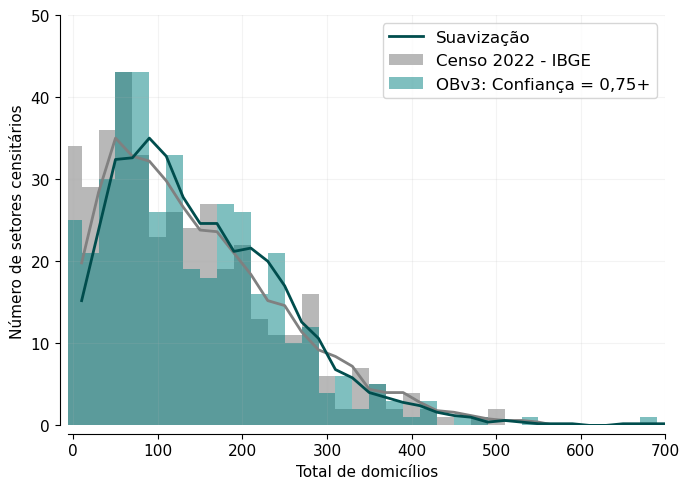

In [332]:
fig, ax = plt.subplots(1, figsize=(7,5))

res_count_census = reference_df_high["v0002"].astype(int).values
minv, maxv = res_count_census.min(), res_count_census.max()
print(minv, maxv)
width = 20
bins = np.arange(0, 900+width, width)

vals, bins_ = np.histogram(res_count_census, bins)

ax.bar(bins_[:-1], vals, width=width, alpha=0.8, label="Censo 2022 - IBGE", color="#a7a7a7")
ax.bar(bins_[:-1], vals2, width=width, alpha=0.5, color="#008080", label="OBv3: Confiança = 0,75+")

def smooth(y, k=5):
    kernel = np.ones(k) / k
    return np.convolve(y, kernel, mode="same")

vals_s = smooth(vals, k=5)
vals_s2 = smooth(vals2, k=5)
centers = (bins_[:-1] + bins_[1:]) / 2

ax.plot(centers, vals_s, lw=2, color="#808080")
ax.plot(centers, vals_s2, lw=2, alpha=1, color="#004d4d", label="Suavização")


ax.set_xlim([-6, 700])
ax.set_ylim([0, 50])
ax.set_xlabel("Total de domicílios", fontsize=11)
ax.set_ylabel("Número de setores censitários", fontsize=11)

for axis in [ax]:
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_position(("outward", 6))
    ax.spines['bottom'].set_position(("outward", 6))
    ax.grid(alpha=0.15)
    ax.tick_params(labelsize=11)

ax.legend(prop={'size': 12})
fig.tight_layout()
fig.savefig("C:/Users/Higor Monteiro/Pictures/tanta_slides/orov_survey/residencia_por_setor_censo_obv3.png", dpi=300, bbox_inches="tight")

1 881


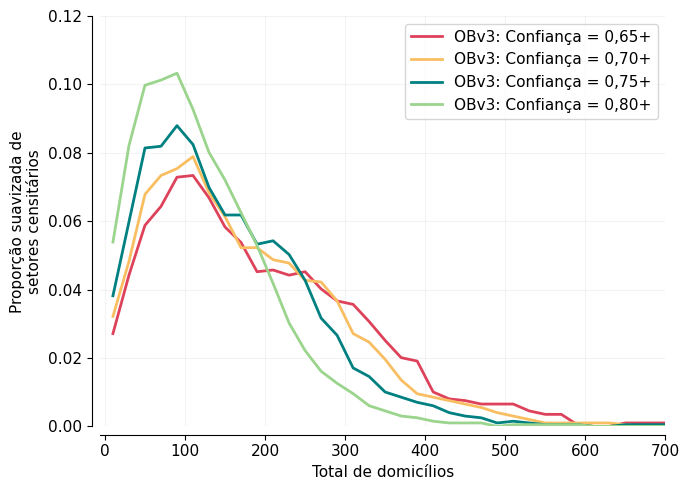

In [333]:
count_arr_list = [
    elem[f"total_households_{suffix}"].astype(int).values for elem, suffix in zip(household_n, modes)
]

minv = max([ elem.min() for elem in count_arr_list ])
maxv = max([ elem.max() for elem in count_arr_list ])
print(minv, maxv)

width = 20
bins = np.arange(0, maxv+width, width)
vals0, bins_ = np.histogram(count_arr_list[0], bins)
vals1, bins_ = np.histogram(count_arr_list[1], bins)
vals2, bins_ = np.histogram(count_arr_list[2], bins)
vals3, bins_ = np.histogram(count_arr_list[3], bins)

def smooth(y, k=5):
    kernel = np.ones(k) / k
    return np.convolve(y, kernel, mode="same")

fig, ax = plt.subplots(1, figsize=(7,5))

linestyles = ["-", "-", "-", "-"]
colors = ["#de425b", "#f9be62", "#008080", "#9ad48d"]
labels = [
    "OBv3: Confiança = 0,65+",
    "OBv3: Confiança = 0,70+",
    "OBv3: Confiança = 0,75+",
    "OBv3: Confiança = 0,80+",
]

for arr, ls, lab, color in zip(count_arr_list, linestyles, labels, colors):
    vals, edges = np.histogram(arr, bins=bins)

    # normalize to proportions (so they’re comparable)
    vals = vals / vals.sum()
    vals_s = smooth(vals, k=5)
    centers = (edges[:-1] + edges[1:]) / 2

    #ax.step(edges[:-1], vals, where="post", color=color, linestyle=ls, linewidth=2, label=lab)
    ax.plot(centers, vals_s, linestyle=ls, linewidth=2, label=lab, color=color)

ax.set_xlim([-6, 700])
ax.set_ylim([0, 0.12])
ax.set_xlabel("Total de domicílios", fontsize=11)
ax.set_ylabel("Proporção suavizada de\nsetores censitários", fontsize=11)

for axis in [ax]:
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_position(("outward", 6))
    ax.spines['bottom'].set_position(("outward", 6))
    ax.grid(alpha=0.15)
    ax.tick_params(labelsize=11)

ax.legend(prop={'size': 11})
fig.tight_layout()
fig.savefig("C:/Users/Higor Monteiro/Pictures/tanta_slides/orov_survey/residencia_por_setor_obv3_confidence.png", dpi=300, bbox_inches="tight")

0.3333333333333333 8.0


Text(1.55, 0.1, 'Confiança = 0,75+')

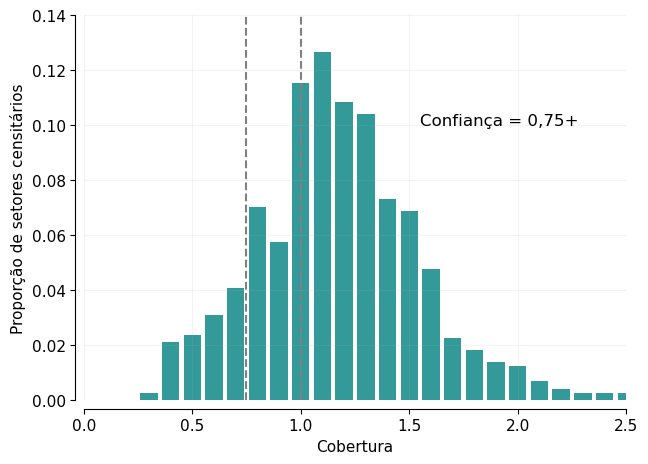

In [366]:
fig, ax = plt.subplots(1, figsize=(7,5))

cov_high = macico_info["coverage_indicator_high"].values
cov_high = cov_high[~np.isinf(cov_high)]

minv, maxv = cov_high.min(), cov_high.max()
print(minv, maxv)
width = 0.1
bins = np.arange(0, maxv+width, width)

vals, bins_ = np.histogram(cov_high, bins)

vals_s = vals / vals.sum()

ax.bar(bins_[:-1], vals_s, width=width-0.2*width, alpha=0.8, label="Censo 2022 - IBGE", color="#008080")

ax.set_xlim([0, 2.5])
ax.set_ylim([0, 0.14])
ax.set_xlabel("Cobertura", fontsize=11)
ax.set_ylabel("Proporção de setores censitários", fontsize=11)

for axis in [ax]:
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_position(("outward", 6))
    ax.spines['bottom'].set_position(("outward", 6))
    ax.grid(alpha=0.15)
    ax.tick_params(labelsize=11)

ax.axvline(x=0.75, ls="--", color="#808080")
ax.axvline(x=1.0, ls="--", color="#808080")

ax.text(x=1.55, y=0.10, s="Confiança = 0,75+", fontsize=12)

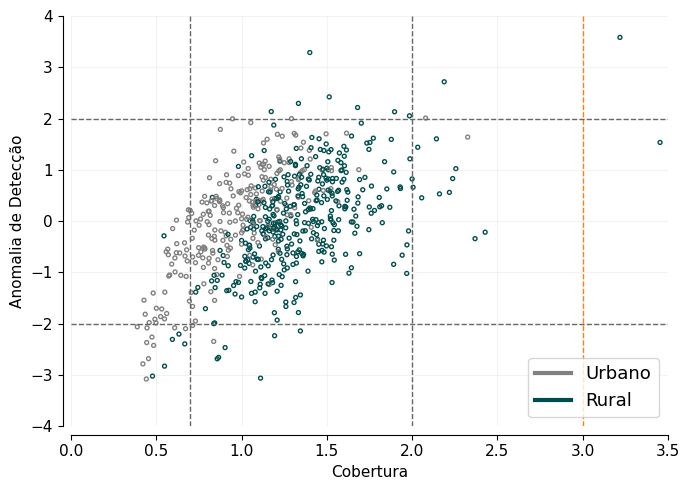

In [555]:
# -- 

fig, ax = plt.subplots(1, figsize=(7,5))

setor_to_situacao = dict(zip(macico_sectors["CD_SETOR"], macico_sectors["SITUACAO"].map({"Urbana": 1, "Rural": 0})))

data = macico_for_model.merge(df[["CD_SETOR", "anomalia_z"]], how="left")[["CD_SETOR", "coverage_indicator_high", "anomalia_z"]]

is_urban = data["CD_SETOR"].map(setor_to_situacao).tolist() 
is_urban_color = [ "#808080" if elem==1 else "#004d4d" for elem in is_urban ]

ax.scatter(data["coverage_indicator_high"], data["anomalia_z"], s=8, facecolor='none', edgecolor=is_urban_color)

ax.set_xlabel("Cobertura", fontsize=11)
ax.set_ylabel("Anomalia de Detecção", fontsize=11)
ax.set_ylim([-4, 4])
ax.set_xlim([0, 3.5])

for axis in [ax]:
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_position(("outward", 6))
    ax.spines['bottom'].set_position(("outward", 6))
    ax.grid(alpha=0.15)
    ax.tick_params(labelsize=11)
    

ax.axvline(x=0.70, lw=1, ls="--", color="#666666")
#ax.axvline(x=1.8, lw=1, ls="--", color="#666666")
ax.axvline(x=2., lw=1, ls="--", color="#666666")
ax.axvline(x=3, lw=1, ls="--", color="tab:orange")
ax.axhline(y=-2, lw=1, ls="--", color="#666666")
ax.axhline(y=2, lw=1, ls="--", color="#666666")

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color="#808080", lw=3),
                Line2D([0], [0], color="#004d4d", lw=3)]


ax.legend(custom_lines, ['Urbano', 'Rural'], loc=4, frameon=True, prop={'size':13})
fig.tight_layout()
fig.savefig("C:/Users/Higor Monteiro/Pictures/tanta_slides/orov_survey/indicadores_per_sector.png", dpi=300, bbox_inches="tight")

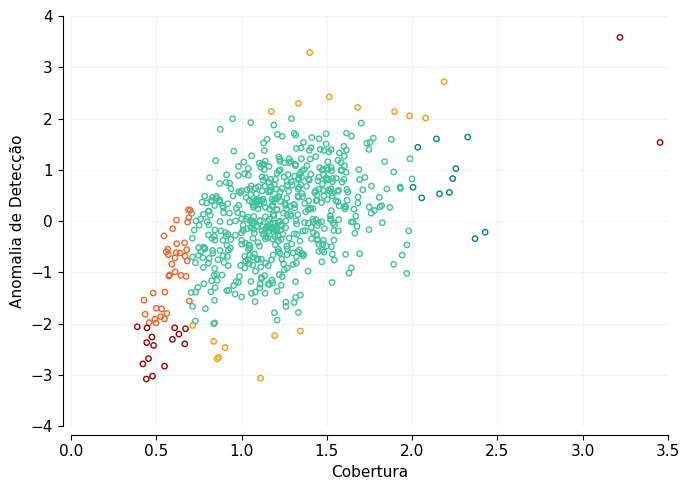

In [556]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, figsize=(7,5))

setor_to_situacao = dict(zip(
    macico_sectors["CD_SETOR"],
    macico_sectors["SITUACAO"].map({"Urbana": 1, "Rural": 0})
))

data = (
    macico_for_model
    .merge(df[["CD_SETOR", "anomalia_z"]], how="left", on="CD_SETOR")
    [["CD_SETOR", "coverage_indicator_high", "anomalia_z"]]
    .copy()
)

cov = data["coverage_indicator_high"].astype(float)
ano = data["anomalia_z"].astype(float)

# ----------------------------
# Risk groups (your rules)
# ----------------------------
# G1: VERY LOW RISK -> cov in [0.7, 2.0] and anom in [-2, 2]
g1 = (cov >= 0.7) & (cov <= 2.0) & (ano >= -2) & (ano <= 2)

# G2: LOW TO MID RISK -> cov in (2.0, 2.5] and anom in [-2, 2]
g2 = (cov > 2.0) & (cov <= 2.5) & (ano >= -2) & (ano <= 2)

# G3: VERY HIGH RISK -> cov > 2.5 (any anom)
g3 = (cov > 3)

# G4a: VERY HIGH RISK -> cov < 0.7 and anom < -2
g4a = (cov < 0.7) & (ano < -2)

# G4b: HIGH RISK -> cov < 0.7 and anom in [-2, 2]
g4b = (cov < 0.7) & (ano >= -2) & (ano <= 2)

# G4c: MID RISK -> cov in [0.7, 2.0] and (anom < -2 or anom > 2)
g4c = (cov >= 0.7) & (cov <= 2.0) & ((ano < -2) | (ano > 2))

# Anything not captured (e.g. cov < 0.7 and anom > 2, etc.)
# We'll call it "OTHER / REVIEW"
other = ~(g1 | g2 | g3 | g4a | g4b | g4c)

data["risk_group"] = np.select(
    [g1, g2, g3, g4a, g4b, g4c, other],
    [
        "G1 low risk",
        "G2 low-mid risk",
        "G3 very high risk (cov>2.5)",
        "G4a very high risk (low cov & anom<-2)",
        "G4b high risk (low cov)",
        "G4c mid risk (anom outlier)",
        "OTHER / review"
    ],
    default="OTHER / review"
)

# ----------------------------
# Color mapping (edit freely)
# ----------------------------
color_map = {
    "G1 low risk": "#3cc396",
    "G2 low-mid risk": "#008080",
    "G3 very high risk (cov>2.5)": "#990000",
    "G4a very high risk (low cov & anom<-2)": "#990000",
    "G4b high risk (low cov)": "#f16427",
    "G4c mid risk (anom outlier)": "#f69b09",
    "OTHER / review": "#f69b09"
}
data["color"] = data["risk_group"].map(color_map)

# ----------------------------
# Scatter (colored by group)
# ----------------------------
ax.scatter(
    cov, ano,
    s=15,
    facecolor="none",
    edgecolor=data["color"],
    alpha=1.0,
    #edgecolors="none"   # change to "#808080" if you want outlines
)

ax.set_xlabel("Cobertura", fontsize=11)
ax.set_ylabel("Anomalia de Detecção", fontsize=11)
ax.set_ylim([-4, 4])
ax.set_xlim([0, 3.5])

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_position(("outward", 6))
ax.spines['bottom'].set_position(("outward", 6))
ax.grid(alpha=0.15)
ax.tick_params(labelsize=11)

# Optional:
fig.tight_layout()
fig.savefig("C:/Users/Higor Monteiro/Pictures/tanta_slides/orov_survey/indicadores_per_sector_risk.png", dpi=300, bbox_inches="tight")

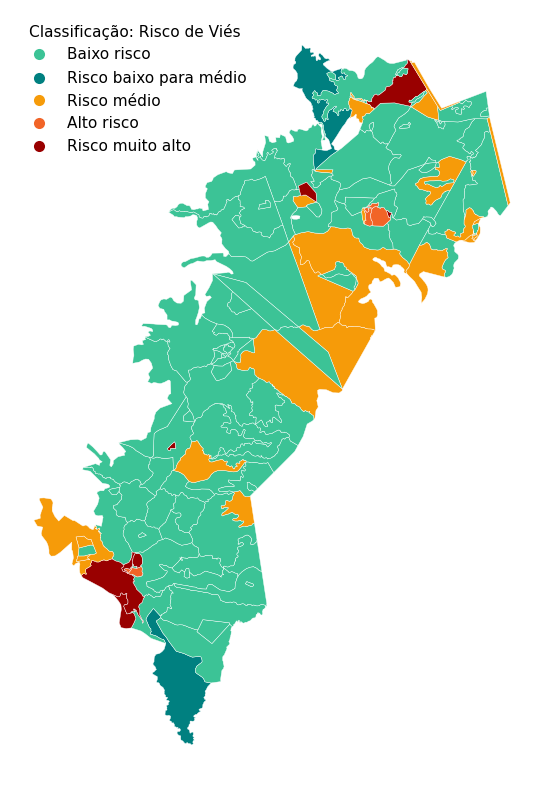

In [587]:
# -- map
fig, ax = plt.subplots(1, figsize=(10,10))

sectors_risk = macico_sectors[macico_sectors["CD_SETOR"].isin(df["CD_SETOR"])]
sectors_risk = sectors_risk[sectors_risk["NM_MUN"].isin(selected_mun)]

sectors_risk = sectors_risk.merge(data[["CD_SETOR", "color"]])

sectors_risk.plot(ax=ax, color=sectors_risk["color"], edgecolor='white', linewidth=0.3)

for axis in [ax]:
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(0)
    ax.set_yticks([])
    ax.set_xticks([])

from matplotlib.lines import Line2D

color_map = {
    "Baixo risco": "#3cc396",
    "Risco baixo para médio": "#008080",
    "Risco médio": "#f69b09",
    "Alto risco": "#f16427",
    "Risco muito alto": "#990000",
}


legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markerfacecolor=color,
        markeredgecolor='none',
        markersize=8,
        label=label
    )
    for label, color in color_map.items()
]

ax.legend(
    handles=legend_elements,
    title="Classificação: Risco de Viés",
    prop={'size': 11},
    title_fontsize=11,
    frameon=False,
    loc="upper left"
)
fig.savefig("C:/Users/Higor Monteiro/Pictures/tanta_slides/orov_survey/indicadores_per_sector_risk_map.png", dpi=350, bbox_inches="tight")

,CD_SETOR,coverage_indicator_high,anomalia_z,risk_group,color
0,230015005000001,0.729282,-0.809110,G1 low risk,#3cc396
1,230015005000002,0.668224,-0.679842,G4b high risk (low cov),#f16427
2,230015005000003,0.617021,-0.615061,G4b high risk (low cov),#f16427
3,230015005000004,0.608696,-0.716852,G4b high risk (low cov),#f16427
4,230015005000005,0.698254,0.211575,G4b high risk (low cov),#f16427
...,...,...,...,...,...
698,231160305000041,0.836364,-2.343300,G4c mid risk (anom outlier),#f69b09
699,231160325000003,1.142857,-0.146321,G1 low risk,#3cc396
700,231160325000005,1.160305,0.759165,G1 low risk,#3cc396
701,231160330000001,0.977679,0.164913,G1 low risk,#3cc396
